In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm, trange

In [2]:
def projection_2d(nx, ny, lx, ly, Re):
    dx = lx / (nx - 1)
    dy = ly / (ny - 1)
    Re = Re
    nu= 0.1
    nt = 10000
    dt = 0.001
    rho = 1.0
    u = np.ones((ny, nx))
    v = np.zeros((ny, nx))
    u_star = np.zeros((ny, nx))
    v_star = np.zeros((ny, nx))
    p = np.zeros((ny, nx))
    u_new = np.zeros((ny, nx))
    v_new = np.zeros((ny, nx))
    error_limit = 1e-4

    u, v, p = initial_condition(u, v, p)
    
    t = trange(nt)

    for n in t:
        for j in range(1,ny-1):
            for i in range(1,nx-1):
                if u[i,j] > 0:
                    u_x_part = u[j,i] - u[j,i-1]
                    v_x_part = v[j,i] - v[j,i-1]
                else:
                    u_x_part = u[j,i+1] - u[j,i]
                    v_x_part = v[j,i+1] - v[j,i]                    
                if v[i,j] > 0:
                    u_y_part = u[j,i] - u[j-1,i]
                    v_y_part = v[j,i] - v[j-1,i]
                else:
                    u_y_part = u[j+1,i] - u[j,i]
                    v_y_part = v[j+1,i] - v[j,i]

                u_star[j,i] = ( nu * ( dt*(u[j,i+1]-2*u[j,i]+u[j,i-1])/dx**2 + dt*(u[j+1,i]-2*u[j,i]+u[j-1,i])/dy**2 ) 
                        - u[j,i]*dt*(u_x_part)/(dx) - v[j,i]*dt*(u_y_part)/(dy) )/2 + u[j,i]
                
                v_star[j,i] = ( nu * ( dt*(v[j,i+1]-2*v[j,i]+v[j,i-1])/dx**2 + dt*(v[j+1,i]-2*v[j,i]+v[j-1,i])/dy**2 ) 
                        - u[j,i]*dt*(v_x_part)/(dx) - v[j,i]*dt*(v_y_part)/(dy) )/2 + v[j,i]
    
        # boundary conditions
        u_star, v_star = boundary_condition(u_star, v_star)
    
        # pressure equation
        A = np.zeros((nx * ny, nx * ny))
        b = np.zeros(nx * ny)
    
        for j in range(ny):
            for i in range(nx):
                k = j * nx + i
                if i == 0 or i == nx - 1:
                    A[k, k] = 1
                    b[k] = p[j, i]
                elif j == 0:
                    A[k, k] = 1
                    A[k, k + nx] = -1
                    b[k] = 0
                elif j == ny - 1:
                    A[k, k] = 1
                    A[k, k - nx] = -1
                    b[k] = 0
                else:
                    A[k, k] = -2 * (dx ** 2 + dy ** 2)
                    A[k, k - 1] = dy ** 2
                    A[k, k + 1] = dy ** 2
                    A[k, k - nx] = dx ** 2
                    A[k, k + nx] = dx ** 2
                    b[k] = 2 * (dx**2 * dy**2) * ( rho*(u_star[j,i+1]-u_star[j,i-1])/(2*dx) + rho*(v_star[j+1,i]-v_star[j-1,i])/(2*dy) ) / dt           
                    
        p_new = np.linalg.solve(A, b)
        p_new = p_new.reshape(ny, nx)       
              
        # next u and v    
        for j in range(1,ny-1):
            for i in range(1,nx-1):
                u_new[j,i] = u_star[j,i] - (0.25*dt/dx)*(p_new[j,i+1]-p_new[j,i-1])
                v_new[j,i] = v_star[j,i] - (0.25*dt/dy)*(p_new[j+1,i]-p_new[j-1,i])
        
        # boundary conditions
        u_new, v_new = boundary_condition(u_new, v_new)
        
        # error
        u_diff_norm = np.linalg.norm(u_new - u)
        v_diff_norm = np.linalg.norm(v_new - v)
        u_norm = np.linalg.norm(u)
        v_norm = np.linalg.norm(v)

        error_u = u_diff_norm / u_norm if u_norm != 0 else u_diff_norm
        error_v = v_diff_norm / v_norm if v_norm != 0 else v_diff_norm

        if error_u < error_limit and error_v < error_limit:
            u[:, :] = u_new[:, :]
            v[:, :] = v_new[:, :]
            print(n)
            break
        u[:, :] = u_new[:, :]
        v[:, :] = v_new[:, :]
        
        t.set_postfix(error_u = error_u, error_v = error_v)

    # Compute vorticity
    vorticity = np.zeros((ny, nx))

    for j in range(1, ny - 1):
        for i in range(1, nx - 1):
            vorticity[j, i] = (v[j, i + 1] - v[j, i - 1]) / (2 * dx) - (u[j + 1, i] - u[j - 1, i]) / (2 * dy)

    vorticity[0, :] = 0
    vorticity[-1, :] = 0
    vorticity[:, 0] = 0
    vorticity[:, -1] = 0
    
    return u, u, p_new, vorticity

def boundary_condition(u,v):
    u[0, :] = 0
    u[-1, :] = 5.0
    u[:, 0] = 0
    u[:, -1] = 0
    
    v[0, :] = 0
    v[-1, :] = 0
    v[:, 0] = 0
    v[:, -1] = 0

    return u, v

def initial_condition(u, v, p):
    u[-1, :] = 5.0

    return u, v, p


  0%|          | 0/10000 [00:00<?, ?it/s] 11%|█         | 1078/10000 [03:50<31:43,  4.69it/s, error_u=4.53e-5, error_v=0.0001]    


1078


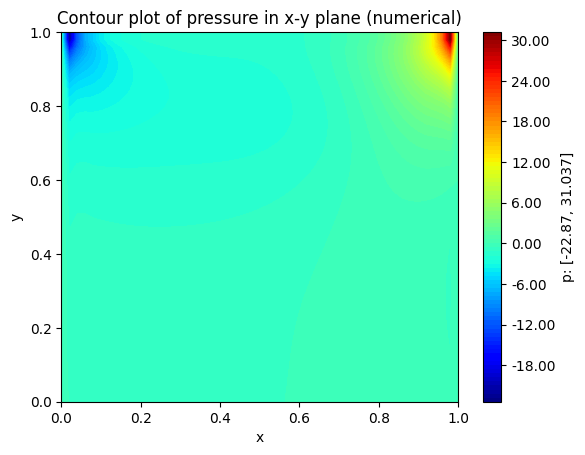

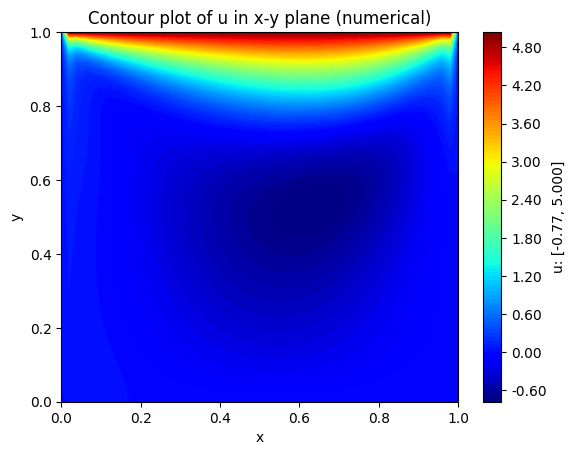

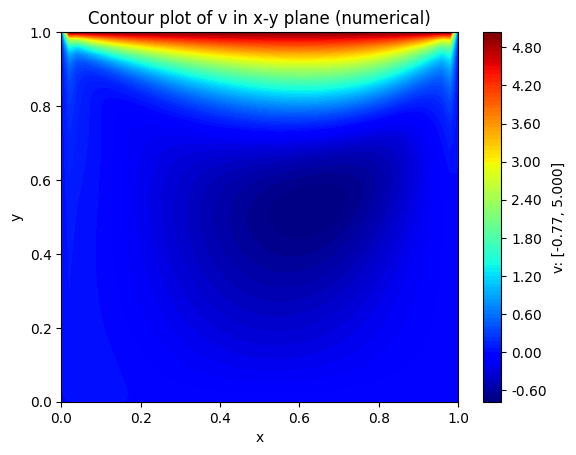

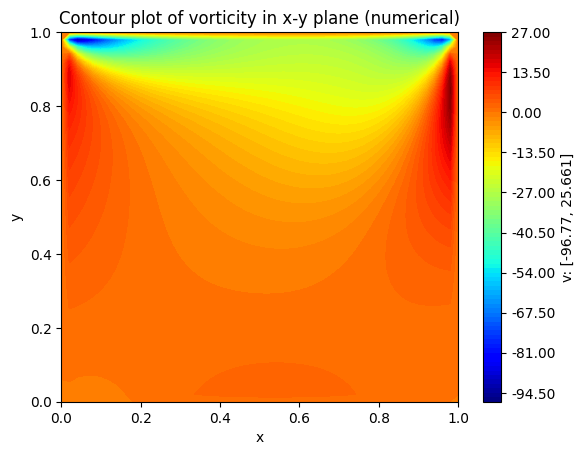

In [3]:
res = 51
lx = 1
ly = 1
Re = 50
u_errors = []
p_errors = []


u_numerical, v_numerical, p_numerical, vorticity = projection_2d(res, res, lx, ly, Re)    

x_a = np.linspace(0, lx, res)
y_a = np.linspace(0, ly, res)
X, Y = np.meshgrid(x_a, y_a)

#plot the u and p in the
plt.figure()
plt.contourf(X, Y, p_numerical, levels=100, cmap='jet')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Contour plot of pressure in x-y plane (numerical)')
plt.colorbar(format='%.2f', label='p: [{:.2f}, {:.3f}]'.format(np.min(p_numerical), np.max(p_numerical)))
plt.show()

plt.figure()
plt.contourf(X, Y, u_numerical, levels=100, cmap='jet')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Contour plot of u in x-y plane (numerical)')
plt.colorbar(format='%.2f', label='u: [{:.2f}, {:.3f}]'.format(np.min(u_numerical), np.max(u_numerical)))
plt.show()

plt.figure()
plt.contourf(X, Y, v_numerical, levels=100, cmap='jet')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Contour plot of v in x-y plane (numerical)')
plt.colorbar(format='%.2f', label='v: [{:.2f}, {:.3f}]'.format(np.min(v_numerical), np.max(v_numerical)))
plt.show()

plt.figure()
plt.contourf(X, Y, vorticity, levels=100, cmap='jet')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Contour plot of vorticity in x-y plane (numerical)')
plt.colorbar(format='%.2f', label='v: [{:.2f}, {:.3f}]'.format(np.min(vorticity), np.max(vorticity)))
plt.show()
